In [961]:
import math
import scipy.io
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
import numpy as np

In [962]:
#Loading the audio file
signal = scipy.io.wavfile.read('signal.wav')
numSamples = len(signal[1])
print('Sample rate is:', signal[0], 'and the number of signals is:', numSamples)
print('This corresponds to', numSamples/signal[0], 'seconds')

Sample rate is: 16000 and the number of signals is: 18091
This corresponds to 1.1306875 seconds


In [963]:
#Mean subtraction
mean = np.mean(signal[1])
print(mean)
meanSub = signal[1] - mean

11756.525786302582


In [964]:
#Pre-emphasis
b = 0.97 #given constant
np.insert(meanSub, 0, 0)
preEmp = meanSub[1:]-b*meanSub[:-1]
print(preEmp)

[ 279946.55422641 -120352.58577359  -41547.25577359 ... -137258.38577359
 -149305.20577359   20760.82422641]


In [965]:
#Computing frames
#Window length 𝐿 set to 25 milliseconds: this is (25/1000)/(1/16000) = 400 samples
#Window shift 𝑆 set to 10 milliseconds: this is (10/1000)/(1/16000) = 160 samples
L = 400
S = 160
#dimensions of the return array are 1+ceil((numSamples-L)/S) rows by L samples
frames = np.zeros((1 + math.ceil((numSamples-L)/S), L))
for k in range(frames.shape[0]):
    for n in range(L):
        ind = k*S+n
        if  ind<len(preEmp):
            frames[k][n] = preEmp[ind]
        else:
            break
print(frames.shape)

(112, 400)


In [966]:
#Applying window function
window = scipy.signal.hamming(L)
for row in range(len(frames)):
    frames[row]*=window
print(frames.shape)

(112, 400)


In [967]:
#Computing the Fourier transform
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
print(fourier.shape)

(112, 512)


In [968]:
#Computing the magnitude and power spectra
magnitude = np.abs(fourier)
print(magnitude.shape)
power = np.square(magnitude)
print(power.shape)

(112, 512)
(112, 512)


(23, 257)
(112, 23)


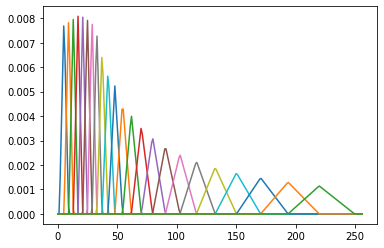

In [969]:
#Mel-filterbank application
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
print(mel_filters.shape)
#Want to take the first 257 values for each frame and matric multiply by the transpose of the mel filters array
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
print(mel.shape)

In [970]:
#taking the log
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
print (mellog.shape)

(112, 23)


In [971]:
#Computing the DCT and “liftering”:
numCoeff = 13 #given
c = np.zeros((mellog.shape[0], numCoeff))
for window in range(c.shape[0]):
    for i in range(c.shape[1]):
        c[window][i] = np.sum(mellog[window]*np.cos((np.arange(mellog.shape[1])+0.5)*(np.pi*i/23)))
print(c.shape)
print(c)

(112, 13)
[[ 5.39047398e+02 -1.88685180e+01  1.07517934e+00 ...  3.45698627e+00
   3.08642436e+00 -8.97549482e-01]
 [ 5.39321231e+02 -1.46728236e+01  2.93520982e+00 ...  1.69609591e+00
   2.85238975e+00  3.67674935e+00]
 [ 5.42209866e+02 -1.27631183e+01  3.78885046e+00 ...  1.85293369e+00
   5.44029391e+00  3.59812471e+00]
 ...
 [ 5.53174233e+02 -4.00653277e+00  1.15639278e+01 ...  6.65937285e-01
  -8.20534569e-01  1.78971848e+00]
 [ 6.34223178e+02 -3.32119165e+01 -6.29091639e+00 ...  1.50696231e+00
  -1.17863057e+00  1.42235144e+00]
 [ 6.41392532e+02 -3.17925877e+01 -4.96015701e+00 ...  8.01044309e-01
  -5.66952745e-01  2.27448909e+00]]


In [972]:
#putting it all together

(13, 112)


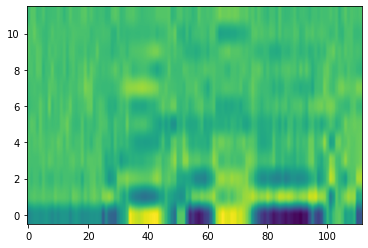

In [973]:
#Visualizing MFCC features
cdata = np.swapaxes(c, 0, 1)
print(cdata.shape)
plt.imshow(cdata[1:13], origin='lower', aspect='auto')

In [974]:
#Calculating diffs and MSE
reference = np.load('reference_mfcc.npy')
diffs = np.absolute(c-reference)
print(diffs)
mse = np.mean(np.square(diffs))
print(mse)

[[7.40232268e-02 3.75111879e-02 3.21652515e-02 ... 3.24017262e-02
  4.51705935e-02 9.45944247e-03]
 [3.20781001e-02 2.47220376e-02 2.18824723e-02 ... 7.83576283e-03
  2.39031537e-02 2.58796725e-02]
 [2.78107187e-02 2.87957693e-02 3.18185680e-02 ... 3.20334723e-03
  1.29192726e-02 6.53694197e-03]
 ...
 [4.73558754e-02 4.09433601e-02 2.33047214e-02 ... 3.40326894e-02
  1.69752676e-02 2.52005081e-04]
 [4.37011632e-01 4.77586762e-02 2.32322490e-02 ... 4.65050913e-03
  1.43293782e-03 2.82376759e-04]
 [3.28351758e-01 6.15475985e-02 3.43622454e-02 ... 1.39649749e-02
  4.30225002e-03 7.91715401e-03]]
0.1323256363989184


(23, 112)


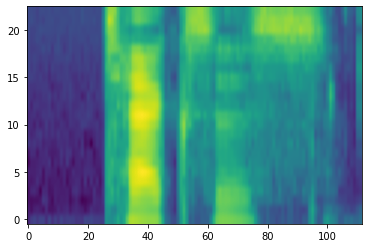

In [975]:
#printing log mel mfsc
mellogdata = np.swapaxes(mellog, 0, 1)
print(mellogdata.shape)
plt.imshow(mellogdata, origin='lower', aspect='auto')

(512, 112)


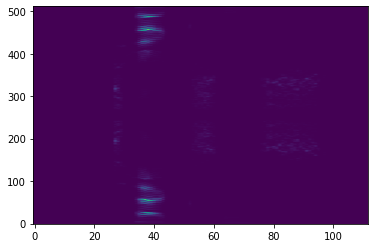

In [976]:
#printing log power spectra
logpower = np.maximum(np.full(power.shape, -50), np.log(power))
logpowerdata = np.swapaxes(power, 0, 1)
print(logpowerdata.shape)
plt.imshow(logpowerdata, origin='lower', aspect='auto')

(13, 1128)


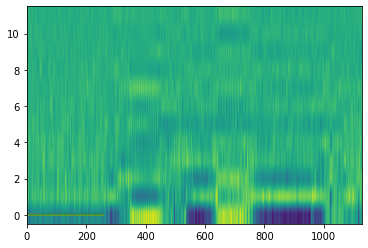

In [977]:
# Visualizing coefficients with smaller window size

#Window length 𝐿 set to 4 milliseconds: this is (4/1000)/(1/16000) = 64 samples
#Window shift 𝑆 set to 1 milliseconds: this is (1/1000)/(1/16000) = 16 samples
L = 64
S = 16
frames = np.zeros((1 + math.ceil((numSamples-L)/S), L))
for k in range(frames.shape[0]):
    for n in range(L):
        ind = k*S+n
        if  ind<len(preEmp):
            frames[k][n] = preEmp[ind]
        else:
            break
window = scipy.signal.hamming(L)
for row in range(len(frames)):
    frames[row]*=window
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
magnitude = np.abs(fourier)
power = np.square(magnitude)
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
numCoeff = 13 #given
c = np.zeros((mellog.shape[0], numCoeff))
for window in range(c.shape[0]):
    for i in range(c.shape[1]):
        c[window][i] = np.sum(mellog[window]*np.cos((np.arange(mellog.shape[1])+0.5)*(np.pi*i/23)))
cdata2 = np.swapaxes(c, 0, 1)
print(cdata2.shape)
plt.imshow(cdata2[1:13], origin='lower', aspect='auto')

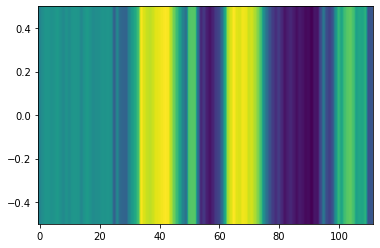

In [978]:
#plotting C1
plt.imshow([cdata[1]], origin='lower', aspect='auto')